<a href="https://colab.research.google.com/github/SOLBhawar/practise1/blob/master/FETAL_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heartbeat:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29414%2F37484%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240921%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240921T054707Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D591e27d0ccce58bef81adc86341eac372b6374c29e3ed7d46a2ab0fd5d064c0f567b1b6a7f0224165830ea9780cf4d0d72e13071a27f9975f07b75d122f3f47024ef3eea832ce37299727ac536062e1128d1b5b7d90640c123ecd785c9eaac57a3213353eb0baf17fe099e59c1825953a47caa223b10d2a927b884a82fcc55caf5bd078bf10cce46de034da743b9bfb96210bc0f82eb3a774c38800fd0b09f4f138fd1a6dca8ff28504b003160c09067b1e5b2ea1851db36de17269065dba5338f8d919ada90a19a3996cdc08a4384d7001b52b2ab1ef3d6d98948550ab99607950d63151484dee6493af5d30f0c3fc917f7d50a41e046f415cc14afee027036'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 103633768 bytes downloaded
Downloaded and uncompressed: heartbeat
Data source import complete.


In [35]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_train.csv
/kaggle/input/heartbeat/ptbdb_abnormal.csv


In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical #Updated import statement
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [37]:
# import dataset
train_df = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header = None)
test_df = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header = None)

In [38]:
# Value of each class
train_df[187].value_counts()

,count
187,
0.0,72471
4.0,6431
2.0,5788
1.0,2223
3.0,641


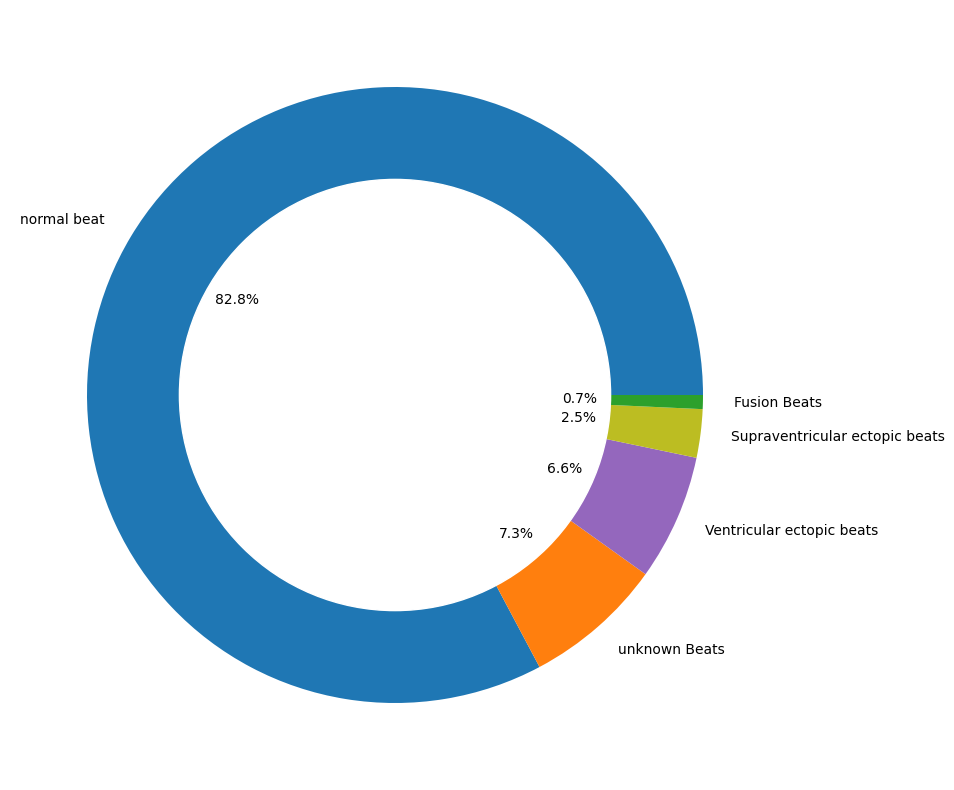

In [39]:
# representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular  beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Resampling for balacing the dataset

In [40]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

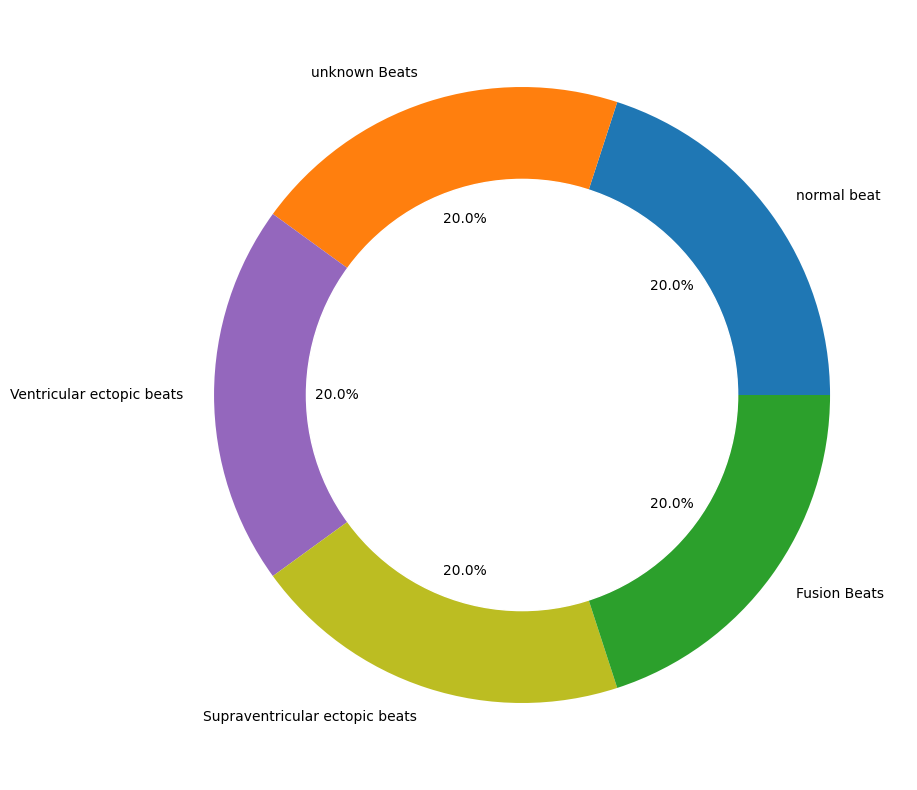

In [41]:
# representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Classes

In [42]:
# randomly sampling from each class
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [43]:
# peek on classes
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
51390,0.981061,0.986742,0.732955,0.429924,0.390152,0.350379,0.301136,0.253788,0.225379,0.174242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72893,0.995833,1.000000,0.387500,0.045833,0.125000,0.220833,0.220833,0.216667,0.312500,0.291667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78866,1.000000,0.979487,0.767949,0.416667,0.312821,0.278205,0.251282,0.228205,0.220513,0.208974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80940,1.000000,0.731343,0.345149,0.195896,0.194030,0.190299,0.171642,0.173507,0.166045,0.169776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
83148,0.661442,0.556426,0.432602,0.313480,0.180251,0.103448,0.026646,0.009404,0.000000,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


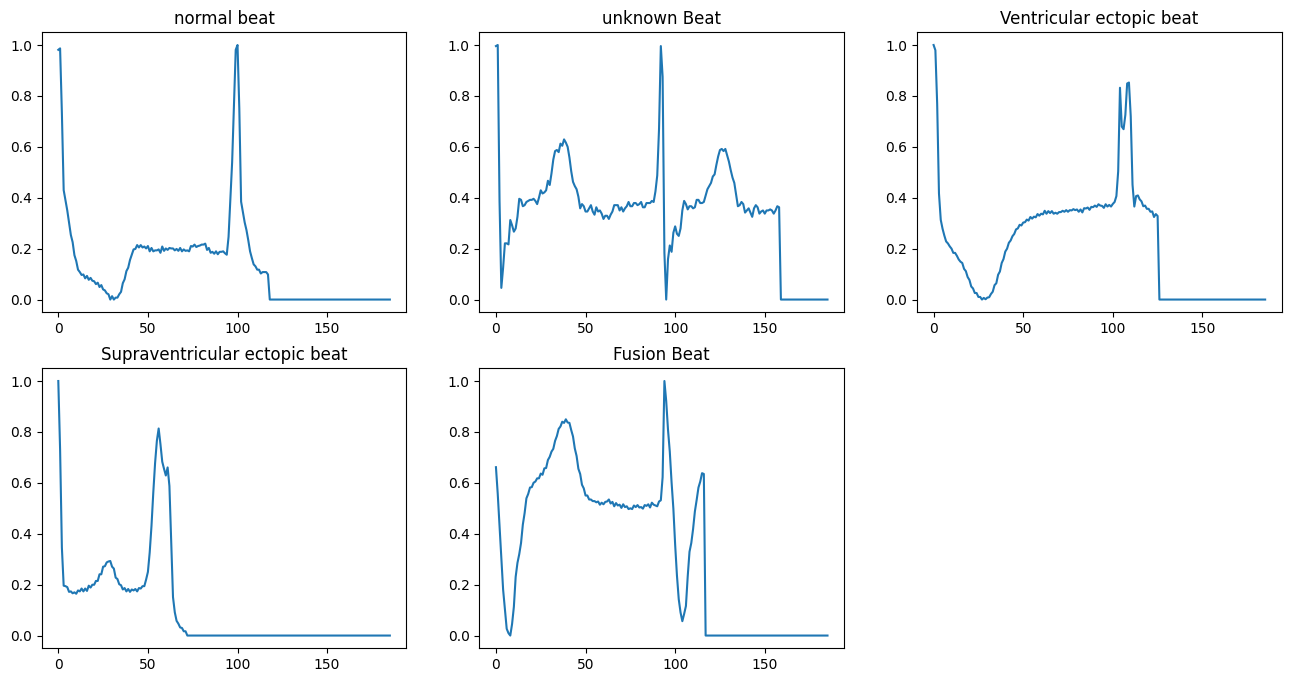

In [44]:
# plotting classes ECG
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# veb
plt.subplot(2, 3, 3)
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# seb
plt.subplot(2, 3, 4)
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# fusion
plt.subplot(2, 3, 5)
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

## Signal heatmap

In [45]:
def plot_hist(class_number,size,min_):
    # get the class data
    img=train_df.loc[train_df[187]==class_number].values
    # crop it
    img=img[:,min_:size]
    # creates a continous steam of data
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


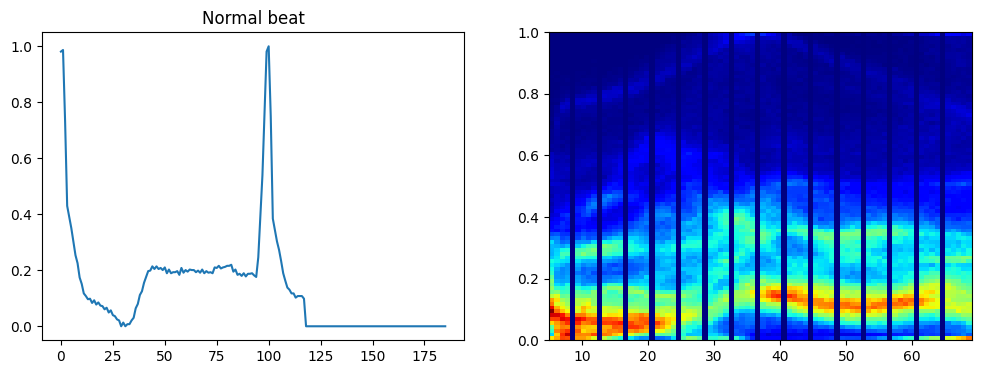

In [46]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[0,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)
plot_hist(0,70,5)

900000
900000


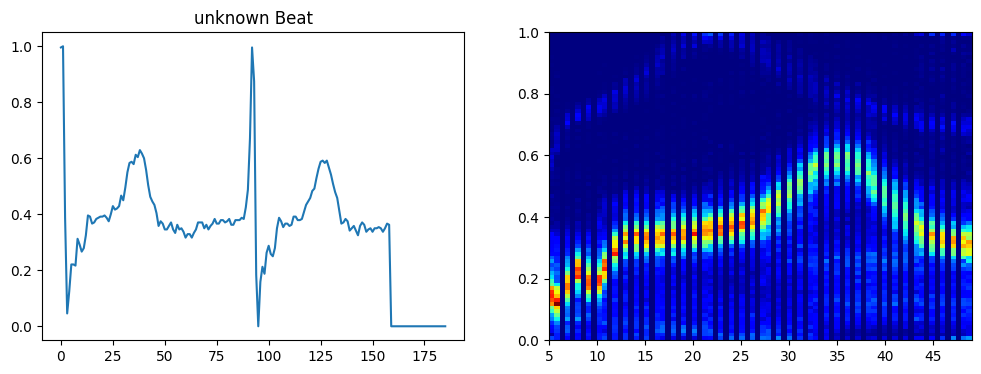

In [47]:
# unknown
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
plt.subplot(1, 2, 2)
plot_hist(1,50,5)

600000
600000


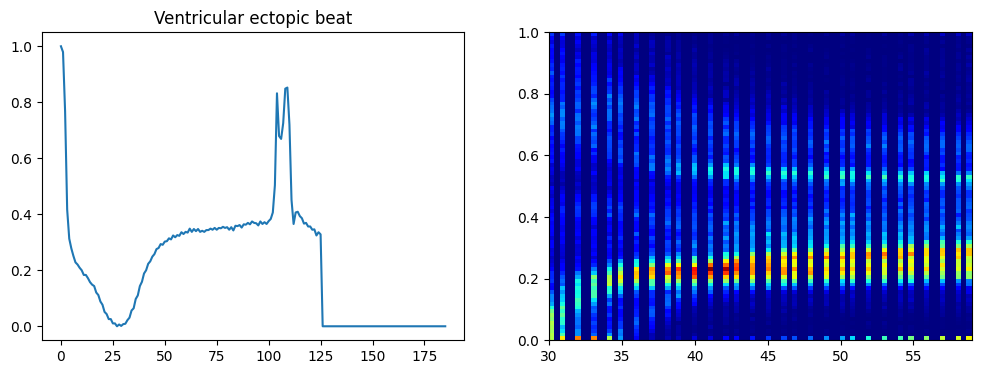

In [48]:
# veb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
plt.subplot(1, 2, 2)
plot_hist(2,60,30)

700000
700000


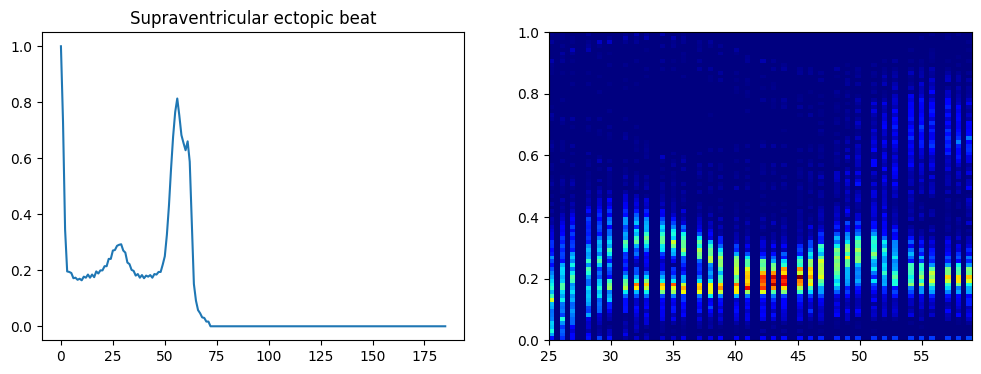

In [49]:
# seb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
plt.subplot(1, 2, 2)
plot_hist(3,60,25)

640000
640000


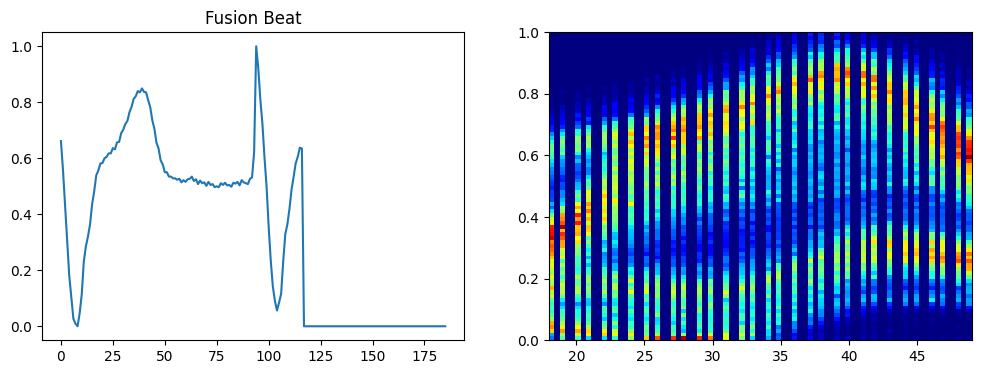

In [50]:
# fusion
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
plt.subplot(1, 2, 2)
plot_hist(4,50,18)

## Pretreat

In [51]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

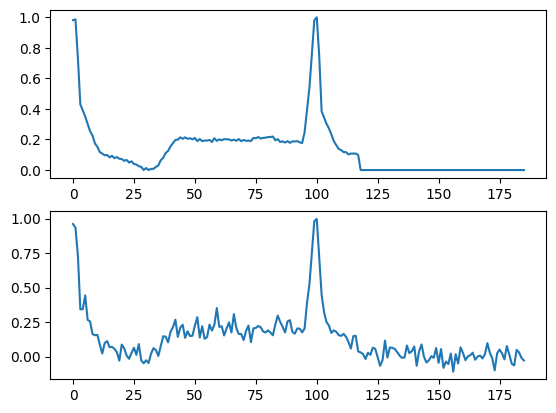

In [52]:
tempo=classes.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(classes.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [53]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [54]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [55]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])


    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [56]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [57]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])


    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)] # Changed 'best_model.h5' to 'best_model.keras'

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.keras') # Changed 'best_model.h5' to 'best_model.keras'
    return(model,history)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 112s 35ms/step - accuracy: 0.8855 - loss: 0.3206 - val_accuracy: 0.9464 - val_loss: 0.1522
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 140s 34ms/step - accuracy: 0.9707 - loss: 0.0839 - val_accuracy: 0.9314 - val_loss: 0.2164
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 143s 35ms/step - accuracy: 0.9815 - loss: 0.0550 - val_accuracy: 0.9586 - val_loss: 0.1426
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 137s 33ms/step - accuracy: 0.9877 - loss: 0.0370 - val_accuracy: 0.9536 - val_loss: 0.1563
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 145s 34ms/step - accuracy: 0.9902 - loss: 0.0306 - val_accuracy: 0.9631 - val_loss: 0.1432
Accuracy: 95.86%


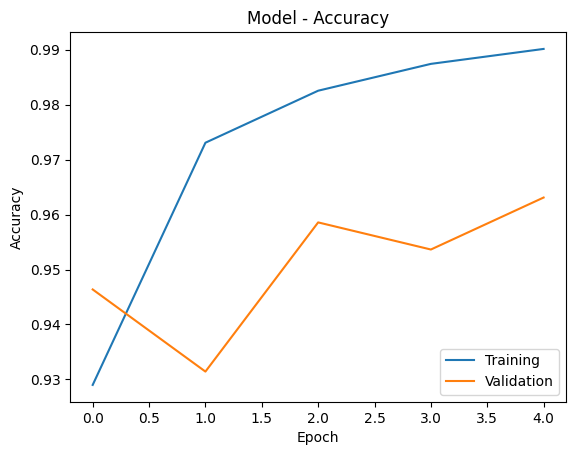

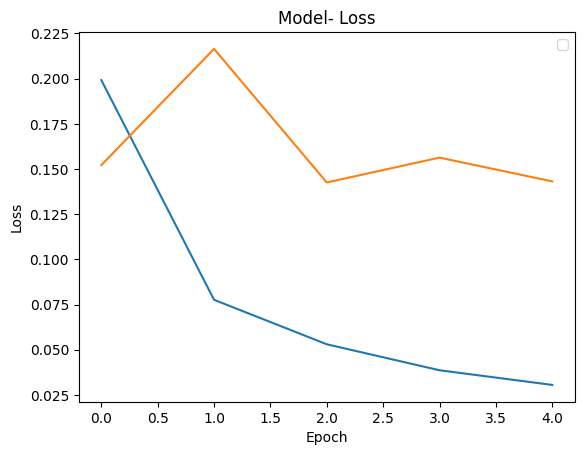

685/685 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [58]:
# Call the network function and assign the returned values to model and history
model, history = network(X_train, y_train, X_test, y_test)

evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [60]:

encoder = preprocessing.LabelEncoder()
encoder.fit(target_train)
Y_train = encoder.transform(target_train)
encoder.fit(target_test)
Y_test = encoder.transform(target_test)

In [61]:
nsamples, nx, ny = X_train.shape
train_dataset = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
test_dataset = X_test.reshape((nsamples,nx*ny))


In [62]:
accu = []
prec = []
recc = []
f1   = []
models =[]

In [63]:
ytest = Y_test

<h1> DecisionTree<\h1>


In [64]:

dtree_model = DecisionTreeClassifier(max_depth = 100).fit(train_dataset, Y_train)
dt_pred = dtree_model.predict(test_dataset)

# creating a confusion matrix
#cm = confusion_matrix(Y_test, dtree_predictions)


accuracy_score(Y_test, dt_pred)#, normalize=False)

0.9279645532614654

In [65]:
print('Accuracy Score : ' + str(accuracy_score(ytest, dt_pred)))
print('Precision Score : ' + str(precision_score(ytest,dt_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,dt_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,dt_pred,average='macro')))

# Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,dt_pred)))


accu.append(accuracy_score(ytest, dt_pred))
prec.append(precision_score(ytest,dt_pred,average='macro'))
recc.append(recall_score(ytest,dt_pred,average='macro'))
f1.append(f1_score(ytest,dt_pred,average='macro'))
models.append("Decision Tree" )

Accuracy Score : 0.9279645532614654
Precision Score : 0.7024853999998487
Recall Score : 0.8363557094320306
F1 Score : 0.7567634295132339
Confusion Matrix : 
[[17021   433   336   114   214]
 [  133   393    14     3    13]
 [  113    12  1273    27    23]
 [   28     0    16   116     2]
 [   64    10    21     1  1512]]


<h1>Logistic Regression<\h1>

In [66]:
clf = LogisticRegression(random_state=0).fit(train_dataset, Y_train)
lr_pred = clf.predict(test_dataset)



In [67]:
print('Accuracy Score : ' + str(accuracy_score(ytest, lr_pred)))
print('Precision Score : ' + str(precision_score(ytest,lr_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,lr_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,lr_pred,average='macro')))

# Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,lr_pred)))



accu.append(accuracy_score(ytest, lr_pred))
prec.append(precision_score(ytest,lr_pred,average='macro'))
recc.append(recall_score(ytest,lr_pred,average='macro'))
f1.append(f1_score(ytest,lr_pred,average='macro'))
models.append("Logistic Regression" )

Accuracy Score : 0.6590535355380961
Precision Score : 0.4419793342217103
Recall Score : 0.7614725454163797
F1 Score : 0.47205550296043686
Confusion Matrix : 
[[11405  2318  2473  1452   470]
 [  127   372    30    21     6]
 [  144    49  1047   158    50]
 [    9     0    11   142     0]
 [   54     5    79     8  1462]]


# Gaussian naive_bayes

In [68]:
gnb = GaussianNB()
nb_pred = gnb.fit(train_dataset, Y_train).predict(test_dataset)


accuracy_score(ytest,nb_pred)

0.18888178329983554

In [69]:
print('Accuracy Score : ' + str(accuracy_score(ytest, nb_pred)))
print('Precision Score : ' + str(precision_score(ytest,nb_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,nb_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,nb_pred,average='macro')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,nb_pred)))

Accuracy Score : 0.18888178329983554
Precision Score : 0.33573706699674966
Recall Score : 0.45874728202303494
F1 Score : 0.177890660826155
Confusion Matrix : 
[[ 2041   108  1165  2497 12307]
 [   37    79    39    55   346]
 [  118     9   289    89   943]
 [    0     0     1   138    23]
 [    1     0     5    14  1588]]


In [70]:
accu.append(accuracy_score(ytest, nb_pred))
prec.append(precision_score(ytest,nb_pred,average='macro'))
recc.append(recall_score(ytest,nb_pred,average='macro'))
f1.append(f1_score(ytest,nb_pred,average='macro'))
models.append("Gaussian naive_bayes" )

# Random forrest

In [71]:
RF = RandomForestClassifier().fit(train_dataset, Y_train)
rf_pred = RF.predict(test_dataset)

In [72]:
print('Accuracy Score : ' + str(accuracy_score(ytest, rf_pred)))
print('Precision Score : ' + str(precision_score(ytest,rf_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,rf_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,rf_pred,average='macro')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,rf_pred)))

Accuracy Score : 0.9772062854010597
Precision Score : 0.9153694033811792
Recall Score : 0.8731010380718371
F1 Score : 0.8930868222509121
Confusion Matrix : 
[[17955    80    56    10    17]
 [  138   415     2     0     1]
 [   71     1  1355    15     6]
 [   30     0    14   118     0]
 [   53     0     5     0  1550]]


In [73]:
accu.append(accuracy_score(ytest, rf_pred))
prec.append(precision_score(ytest,rf_pred,average='macro'))
recc.append(recall_score(ytest,rf_pred,average='macro'))
f1.append(f1_score(ytest,rf_pred,average='macro'))
models.append("Random forrest" )

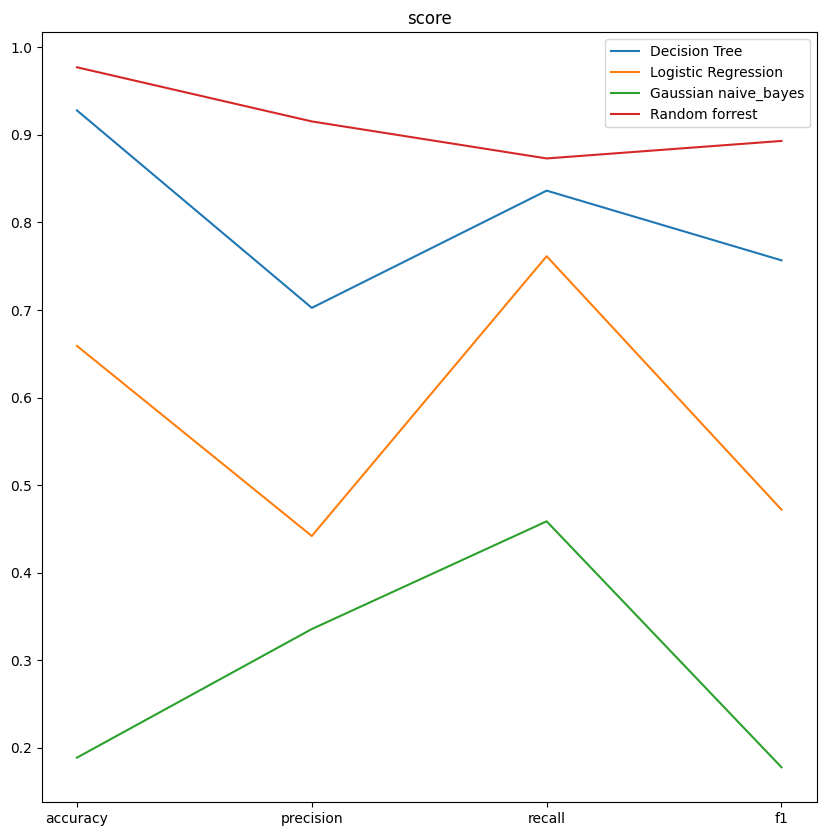

In [74]:
# create data
#x = [1,2,3,4]
x = ['accuracy','precision','recall','f1']
plt.figure(figsize=(10,10))
plt.title('score')
# plot lines
for i in range(len(accu)):
    plt.plot(x,[accu[i],prec[i],recc[i],f1[i]], label = models[i])
plt.legend()
plt.savefig('curves.png')
plt.show()

#svm

In [75]:
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [76]:
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc', SVC(gamma="auto"))])

In [ ]:
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    print(percentile)
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, train_dataset, Y_train)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

1
3
6
10
15
20
30
40
60


In [ ]:
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()


<h1>svm<\h1>


In [ ]:
train_dataset[:2][:]

In [ ]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_model = GridSearchCV(SVC(kernel='linear',max_iter=1000,verbose=True), params_grid, cv=5)
svm_model.fit(train_dataset, Y_train)

In [ ]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n")

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n")
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
svm_pred = final_model.predict(test_dataset)
Y_pred_label = list(encoder.inverse_transform(svm_pred))

In [ ]:
accuracy_score(Y_test, Y_pred_label)

In [ ]:
svm_lin = SVC(kernel='linear',C=10,max_iter=10000,verbose=True).fit(train_dataset, Y_train)

In [ ]:
svm_pred1 = svm_lin.predict(test_dataset)
#accuracy_score(Y_test, svm_pred1)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(ytest, svm_pred1)))
print('Precision Score : ' + str(precision_score(ytest,svm_pred1,average='weighted')))
print('Recall Score : ' + str(recall_score(ytest,svm_pred1,average='weighted')))
print('F1 Score : ' + str(f1_score(ytest,svm_pred1,average='weighted')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,svm_pred2)))

In [ ]:
accu.append(accuracy_score(ytest, svm_pred1))
prec.append(precision_score(ytest,svm_pred1,average='weighted'))
recc.append(recall_score(ytest,svm_pred1,average='weighted'))
f1.append(f1_score(ytest,svm_pred1,average='weighted'))
models.append("linear SVM" )

In [ ]:
svm_pol = SVC(kernel='poly',C=10,max_iter=10000,verbose=True).fit(train_dataset, Y_train)

In [ ]:
svm_pred2 = svm_pol.predict(test_dataset)
#accuracy_score(Y_test, svm_pred2)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(ytest, svm_pred2)))
print('Precision Score : ' + str(precision_score(ytest,svm_pred2,average='weighted')))
print('Recall Score : ' + str(recall_score(ytest,svm_pred2,average='weighted')))
print('F1 Score : ' + str(f1_score(ytest,svm_pred2,average='weighted')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,svm_pred2)))

In [ ]:
accu.append(accuracy_score(ytest, svm_pred2))
prec.append(precision_score(ytest,svm_pred2,average='weighted'))
recc.append(recall_score(ytest,svm_pred2,average='weighted'))
f1.append(f1_score(ytest,svm_pred2,average='weighted'))
models.append("polynomial SVM" )

In [ ]:
svm_rbf = SVC(kernel='rbf',C=10,max_iter=10000,verbose=True).fit(train_dataset, Y_train)

In [ ]:
svm_pred3 = svm_rbf.predict(test_dataset)
#accuracy_score(Y_test, svm_pred3)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(ytest, svm_pred3)))
print('Precision Score : ' + str(precision_score(ytest,svm_pred3,average='weighted')))
print('Recall Score : ' + str(recall_score(ytest,svm_pred3,average='weighted')))
print('F1 Score : ' + str(f1_score(ytest,svm_pred3,average='weighted')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,svm_pred3)))

In [ ]:
accu.append(accuracy_score(ytest, svm_pred3))
prec.append(precision_score(ytest,svm_pred3,average='weighted'))
recc.append(recall_score(ytest,svm_pred3,average='weighted'))
f1.append(f1_score(ytest,svm_pred3,average='weighted'))
models.append("rbf SVM" )

In [ ]:
svm_sig = SVC(kernel='sigmoid',C=10,max_iter=10000,verbose=True).fit(train_dataset, Y_train)

In [ ]:
svm_pred4 = svm_sig.predict(test_dataset)
#accuracy_score(Y_test, svm_pred4)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(ytest, svm_pred4)))
print('Precision Score : ' + str(precision_score(ytest,svm_pred4,average='weighted')))
print('Recall Score : ' + str(recall_score(ytest,svm_pred4,average='weighted')))
print('F1 Score : ' + str(f1_score(ytest,svm_pred4,average='weighted')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,svm_pred4)))

In [ ]:
accu.append(accuracy_score(ytest, svm_pred4))
prec.append(precision_score(ytest,svm_pred4,average='weighted'))
recc.append(recall_score(ytest,svm_pred4,average='weighted'))
f1.append(f1_score(ytest,svm_pred4,average='weighted'))
models.append("sigmoid SVM" )

In [ ]:
# create data
#x = [1,2,3,4]
x = ['accuracy','precision','recall','f1']
plt.figure(figsize=(10,10))
plt.title('score')
# plot lines
for i in range(4):
    plt.plot(x,[accu[i],prec[i],recc[i],f1[i]], label = models[i])
for i in range(4,8):
    plt.plot(x,[accu[i],prec[i],recc[i],f1[i]], label = models[i],linestyle='dashed')
plt.legend()
plt.savefig('curves.png')
plt.show()

In [ ]:
scores = pd.DataFrame({'model':models,'accuracy':accu,'precision':prec,'recall':recc,'f1 score' :f1})

In [ ]:
scores.to_csv('scores.csv')

In [ ]:
scores